# **Machine Learning in Finance II**
## **Labs no. 4 - Gradient Boosting Machines (part 3)**

Author: Michał Woźniak

### What We Will Cover

1. **Theoretical Foundations** (repretition): Mathematical formulation, loss functions, pseudo-residuals, and algorithm pseudocode

2. **From-Scratch Implementations**: Both analytical gradient and PyTorch autograd versions with comparisons

3. **Probabilistic Gradient Boosting**: XGBoostLSS and NGBoost for distributional predictions and uncertainty quantification

4. **Deep Understanding**: Link to comprehensive interactive GBDT explanation resource

## Technical Setup: Running This Notebook Locally with `uv`

### Prerequisites
- Ensure you have `uv` installed on your system. If not, install it following the instructions at [https://github.com/astral-sh/uv](https://github.com/astral-sh/uv)

### Step 1: Initialize a New Project
Navigate to your working directory and initialize a new Python project:
```bash
# Navigate to your project directory
cd /path/to/your/project

# Initialize uv project (if not already initialized)
uv init

# Or if you want to specify Python version
uv init --python 3.11
```

### Step 2: Install Required Dependencies
Install all necessary packages for this notebook:
```bash
# Install core data science packages
uv add numpy pandas scikit-learn scipy torch tqdm

# Install visualization libraries
uv add matplotlib seaborn

# Install probabilistic gradient boosting libraries
uv add xgboostlss ngboost

# Install Jupyter notebook
uv add jupyter ipykernel

# Alternative: Install all at once
uv add numpy pandas scikit-learn scipy torch tqdm matplotlib seaborn xgboostlss ngboost jupyter ipykernel
```

### Step 3: Activate the Environment and Start Jupyter
```bash
# Start Jupyter notebook
uv run jupyter notebook

# Or use Jupyter Lab
uv run jupyter lab
```

### Step 4: Open This Notebook
Once Jupyter starts, navigate to `Labs_no_4_Gradient_Boosting_part_3.ipynb` and open it.

# 1. Theoretical Foundation: Vanilla Gradient Boosting Algorithm

## Introduction

Gradient Boosting is a powerful ensemble learning technique that builds models sequentially, where each new model attempts to correct the errors made by the evious ensemble. Unlike AdaBoost which adjusts sample weights, Gradient Boosting fits new models to the residuals (errors) of the previous predictions.

The key insight is to view boosting as a **numerical optimization problem** in function space, where we iteratively minimize a loss function by moving in e direction of the negative gradient.

## Core Concept

The fundamental idea is to construct an additive model:

$$ F(x) = \sum_{m=1}^{M} \nu h_m(x) $$

where:
- $F(x)$ is the final ensemble model
- $h_m(x)$ is the $m$-th weak learner (typically a decision tree)
- $\nu$ is the learning rate (shrinkage parameter)
- $M$ is the total number of boosting iterations

At each iteration, we fit a new weak learner $h_m(x)$ to the **negative gradient** of the loss function with respect to the current model's predictions.


## Mathematical Formulation

### Loss Function Minimization Framework

Our goal is to find a function $$ F(x) $$ that minimizes the expected loss over the training data:

$$ F^* = \arg\min_{F} \mathbb{E}_{x,y}[L(y, F(x))] $$

In practice, we minimize the empirical loss over the training set:

$$ F^* = \arg\min_{F} \sum_{i=1}^{n} L(y_i, F(x_i)) $$

where $L(y, F(x))$ is a differentiable loss function (e.g., MSE, log-loss).

### Sequential Additive Modeling

We build the model sequentially:

$$ F_m(x) = F_{m-1}(x) + \nu h_m(x) $$

where:

* $F_m(x)$ is the model after iteration ($m$)
* $F_0(x)$ is typically initialized to a constant (e.g., mean of target values)
* $h_m(x)$ is the weak learner fitted at iteration ($m$)

### Gradient Computation

At each iteration (m), we compute the **negative gradient** of the loss function with respect to the current predictions:

$$ r_{im} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]*{F = F*{m-1}} $$

These values $(r_{im})$ are called **pseudo-residuals** and represent the direction in which we should adjust our predictions to minimize the loss.

### Common Loss Functions and Their Gradients

1. **Squared Error (L2 Loss)**:
   $$ L(y, F) = \frac{1}{2}(y - F)^2 $$

   * Gradient: $$ \frac{\partial L}{\partial F} = -(y - F) $$
   * Pseudo-residual: $r = y - F$ (actual residual)

2. **Absolute Error (L1 Loss)**:
   $$ L(y, F) = |y - F| $$

   * Gradient: $$ \frac{\partial L}{\partial F} = -\text{sign}(y - F) $$

3. **Huber Loss**: Combines L1 and L2 loss for robustness

4. **Log-Loss (Binary Classification)**:
   $$ L(y, F) = -y \log(p) - (1-y)\log(1-p) $$

   * where $p = \sigma(F) = \frac{1}{1 + e^{-F}}$

### Fitting the Weak Learner

Instead of fitting $h_m(x)$ to the original targets $(y_i)$, we fit it to the pseudo-residuals:

$$ h_m = \arg\min_{h} \sum_{i=1}^{n} (r_{im} - h(x_i))^2 $$

This is the key insight: **we're using regression trees to approximate the negative gradient of the loss function**.


## Gradient Boosting Algorithm (Pseudocode)

**Input**:

* Training data: $$ {(x_i, y_i)}_{i=1}^{n} $$
* Differentiable loss function: $$ L(y, F(x)) $$
* Number of iterations: M
* Learning rate: $$ \nu \in (0, 1] $$

**Algorithm**:

1. **Initialize** the model with a constant value:
   $$ F_0(x) = \arg\min_{\gamma} \sum_{i=1}^{n} L(y_i, \gamma) $$

   For squared error loss, this is simply:
   $$ F_0(x) = \bar{y} = \frac{1}{n}\sum_{i=1}^{n} y_i $$

2. **For** m = 1 to M:

   a. **Compute pseudo-residuals** for all training samples:
   $$ r_{im} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]*{F = F*{m-1}} \quad \text{for } i = 1, \ldots, n $$

   b. **Fit a weak learner** (e.g., regression tree) $$ h_m(x) $$ to the pseudo-residuals:
   $$ h_m = \arg\min_{h} \sum_{i=1}^{n} (r_{im} - h(x_i))^2 $$

   c. **Update the model**:
   $$ F_m(x) = F_{m-1}(x) + \nu h_m(x) $$

3. **Output** the final model:
   $$ F(x) = F_M(x) = F_0(x) + \nu \sum_{m=1}^{M} h_m(x) $$

**Key Parameters**:

* **Learning rate (ν)**: Controls the contribution of each tree. Smaller values require more trees but often lead to better generalization.
* **Number of iterations (M)**: More iterations can improve training performance but may lead to overfitting.
* **Tree depth**: Typically shallow trees (depth 3–5) work well as weak learners.


# 2. From-Scratch Implementation

We will implement two versions of Gradient Boosting:
1. **Version 1**: Using analytical gradient computation (explicit formula)
2. **Version 2**: Using PyTorch's automatic differentiation

Both implementations will use decision trees as weak learners and demonstrate the gradient boosting mechanism on a regression task.

## Version 1: Gradient Boosting with Analytical Gradient

This implementation explicitly computes the gradient of the loss function. For MSE loss, the gradient is simply the residual: \( y - \hat{y} \).


In [2]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 4)

class GradientBoostingAnalytical:
    """
    Gradient Boosting implementation with analytical gradient computation.
    Uses MSE loss with explicit gradient: gradient = y - y_hat
    """
    def __init__(self, n_estimators: int = 100, learning_rate: float = 0.1,
                 max_depth: int = 3, min_samples_split: int = 2):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

        self.estimators = []
        self.init_value = None
        self.is_trained = False

        # Store training history for visualization
        self.train_losses = []

    def _fit_init_value(self, y: np.array):
        """Initialize with mean of target values (optimal for MSE)"""
        self.init_value = np.mean(y)

    def _compute_gradient_analytical(self, y: np.array, y_hat: np.array):
        """
        Compute negative gradient of MSE loss analytically.
        For L(y, F) = 1/2 * (y - F)^2
        dL/dF = -(y - F)
        Negative gradient: -dL/dF = (y - F) = residuals
        """
        return y - y_hat

    def _predict(self, X: np.array):
        """Internal prediction method"""
        output = np.full(len(X), self.init_value)
        for estimator in self.estimators:
            output += self.learning_rate * estimator.predict(X)
        return output

    def predict(self, X: np.array):
        """Make predictions on new data"""
        if not self.is_trained:
            raise Exception("Model is not trained. Call fit() first.")
        return self._predict(X)

    def fit(self, X: np.array, y: np.array, X_val=None, y_val=None):
        """
        Fit the gradient boosting model.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training data
        y : array-like, shape (n_samples,)
            Target values
        X_val : array-like, optional
            Validation data for tracking loss
        y_val : array-like, optional
            Validation targets
        """
        # Initialize model
        self._fit_init_value(y)
        self.is_trained = True
        self.train_losses = []

        # Boosting iterations
        for m in tqdm(range(self.n_estimators), desc="Training"):
            # Get current predictions
            y_hat = self._predict(X)

            # Compute pseudo-residuals (negative gradient)
            residuals = self._compute_gradient_analytical(y, y_hat)

            # Fit weak learner to residuals
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=42
            )
            tree.fit(X, residuals)

            # Add tree to ensemble
            self.estimators.append(tree)

            # Track training loss
            y_hat_updated = self._predict(X)
            train_loss = mean_squared_error(y, y_hat_updated)
            self.train_losses.append(train_loss)

        return self

print("GradientBoostingAnalytical class defined successfully!")


GradientBoostingAnalytical class defined successfully!


In [3]:
# Generate synthetic regression dataset
np.random.seed(42)
X, y = make_regression(n_samples=500, n_features=10, n_informative=8,
                       noise=10, random_state=42)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")

# Train the model with analytical gradient
model_analytical = GradientBoostingAnalytical(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)

model_analytical.fit(X_train, y_train)

# Make predictions
y_pred_train = model_analytical.predict(X_train)
y_pred_test = model_analytical.predict(X_test)

# Evaluate
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"\n{'='*60}")
print("Gradient Boosting with Analytical Gradient - Results")
print(f"{'='*60}")
print(f"Train MSE: {train_mse:.4f} | Train R²: {train_r2:.4f}")
print(f"Test MSE:  {test_mse:.4f} | Test R²:  {test_r2:.4f}")
print(f"{'='*60}")


Training set size: 400 samples
Test set size: 100 samples
Number of features: 10


Training: 100%|██████████| 100/100 [00:00<00:00, 143.47it/s]



Gradient Boosting with Analytical Gradient - Results
Train MSE: 136.8059 | Train R²: 0.9926
Test MSE:  2866.7135 | Test R²:  0.8751


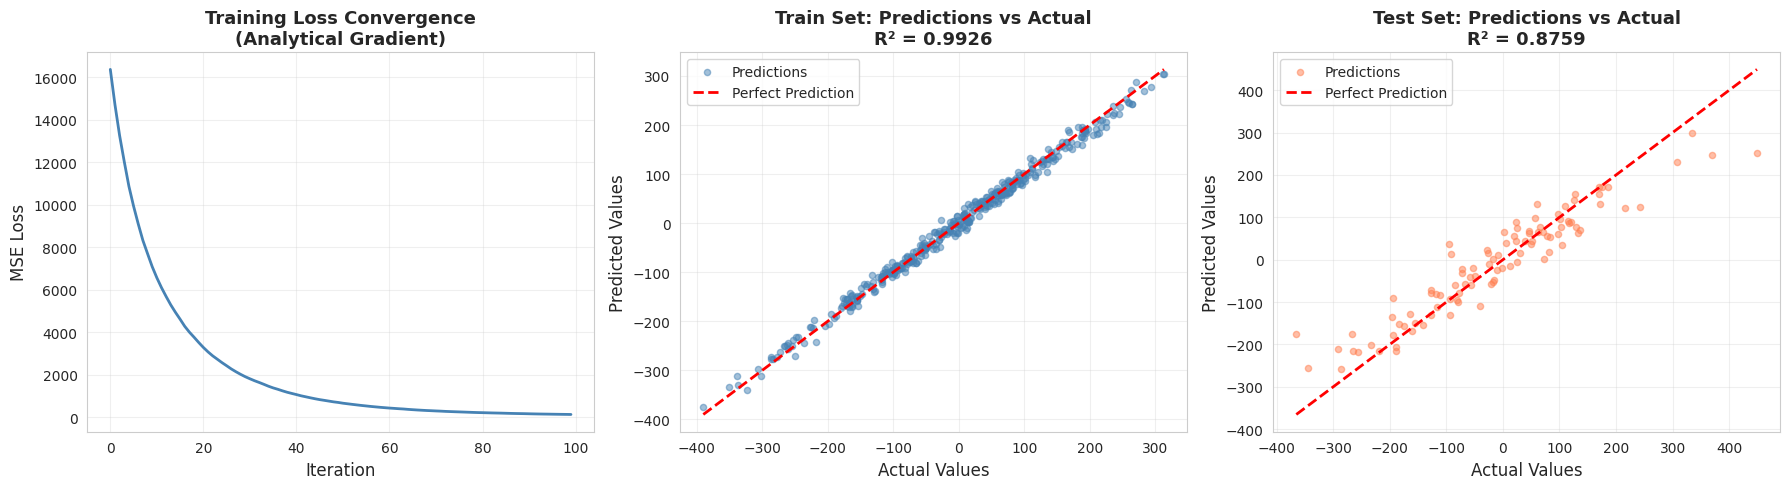

In [7]:
# Visualize results for analytical gradient version
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Training loss over iterations
axes[0].plot(model_analytical.train_losses, linewidth=2, color='steelblue')
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].set_title('Training Loss Convergence\n(Analytical Gradient)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Predictions vs Actual (Train)
axes[1].scatter(y_train, y_pred_train, alpha=0.5, s=20, color='steelblue', label='Predictions')
axes[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Values', fontsize=12)
axes[1].set_ylabel('Predicted Values', fontsize=12)
axes[1].set_title(f'Train Set: Predictions vs Actual\nR² = {train_r2:.4f}',
                  fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Predictions vs Actual (Test)
axes[2].scatter(y_test, y_pred_test, alpha=0.5, s=20, color='coral', label='Predictions')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[2].set_xlabel('Actual Values', fontsize=12)
axes[2].set_ylabel('Predicted Values', fontsize=12)
axes[2].set_title(f'Test Set: Predictions vs Actual\nR² = {test_r2:.4f}',
                  fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Version 2: Gradient Boosting with PyTorch Autograd

This implementation uses PyTorch's automatic differentiation to compute gradients. This approach is more flexible as it allows us to easily experiment with different loss functions without manually deriving gradients.

The key advantage: **we can use any differentiable loss function**, and PyTorch automatically computes the gradient for us!


In [4]:
import torch
from torch.autograd import Variable

class GradientBoostingPyTorch:
    """
    Gradient Boosting implementation using PyTorch automatic differentiation.
    Computes gradients automatically using torch.autograd.
    """
    def __init__(self, n_estimators: int = 100, learning_rate: float = 0.1,
                 max_depth: int = 3, min_samples_split: int = 2):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

        self.estimators = []
        self.init_value = None
        self.is_trained = False

        # Store training history
        self.train_losses = []

    def _fit_init_value(self, y: np.array):
        """Initialize with mean of target values"""
        self.init_value = np.mean(y)

    def _compute_gradient_pytorch(self, y: np.array, y_hat: np.array):
        """
        Compute negative gradient using PyTorch autograd.
        We define loss as NEGATIVE MSE so that gradient points in the right direction.
        Loss = -mean((y - y_hat)^2)
        """
        # Convert to PyTorch tensors
        y_torch = torch.tensor(y, dtype=torch.float32)
        y_hat_torch = Variable(torch.tensor(y_hat, dtype=torch.float32), requires_grad=True)

        # Define loss function (negative MSE for minimization)
        # We use negative because we want to maximize the similarity
        # The gradient will point in the direction to increase similarity
        loss = 0.5 * torch.sum((y_torch - y_hat_torch) ** 2)

            # Why “sum (or half-sum)” matters (vs. mean)
            #
            # If we use the MEAN squared error:
            #     L_mean(y_hat) = (1/n) * Σ (y_j - y_hat_j)^2
            #
            # Then the derivative with respect to each prediction y_hat_i is:
            #     ∂L_mean/∂y_hat_i = (2/n) * (y_hat_i - y_i)
            #
            # The negative gradient (which boosting fits) is:
            #     -∂L_mean/∂y_hat_i = (2/n) * (y_i - y_hat_i)
            #
            # That means each residual is scaled down by a factor of (2/n).
            # For large n (e.g. 10,000 samples), this makes updates extremely small,
            # so the model learns very slowly.
            #
            # Using the SUM (or half-sum) of squared errors avoids this scaling issue:
            #     L_sum(y_hat) = 0.5 * Σ (y_j - y_hat_j)^2
            # gives
            #     ∂L_sum/∂y_hat_i = (y_hat_i - y_i)
            # and
            #     -∂L_sum/∂y_hat_i = (y_i - y_hat_i)
            # which matches the true residuals without the 1/n shrinkage.

        # Compute gradient
        loss.backward()

        # Return gradient as numpy array
        # The gradient from autograd is already the negative gradient we need
        gradient = -y_hat_torch.grad.detach().numpy()

        return gradient

    def _predict(self, X: np.array):
        """Internal prediction method"""
        output = np.full(len(X), self.init_value)
        for estimator in self.estimators:
            output += self.learning_rate * estimator.predict(X)
        return output

    def predict(self, X: np.array):
        """Make predictions on new data"""
        if not self.is_trained:
            raise Exception("Model is not trained. Call fit() first.")
        return self._predict(X)

    def fit(self, X: np.array, y: np.array):
        """
        Fit the gradient boosting model using PyTorch autograd.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training data
        y : array-like, shape (n_samples,)
            Target values
        """
        # Initialize model
        self._fit_init_value(y)
        self.is_trained = True
        self.train_losses = []

        # Boosting iterations
        for m in tqdm(range(self.n_estimators), desc="Training (PyTorch)"):
            # Get current predictions
            y_hat = self._predict(X)

            # Compute pseudo-residuals using PyTorch autograd
            gradient = self._compute_gradient_pytorch(y, y_hat)

            # Fit weak learner to gradient
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=42
            )
            tree.fit(X, gradient)

            # Add tree to ensemble
            self.estimators.append(tree)

            # Track training loss
            y_hat_updated = self._predict(X)
            train_loss = mean_squared_error(y, y_hat_updated)
            self.train_losses.append(train_loss)

        return self

print("GradientBoostingPyTorch class defined successfully!")


GradientBoostingPyTorch class defined successfully!


In [ ]:
# Train the PyTorch version on the same data
model_pytorch = GradientBoostingPyTorch(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)

model_pytorch.fit(X_train, y_train)

# Make predictions
y_pred_train_pt = model_pytorch.predict(X_train)
y_pred_test_pt = model_pytorch.predict(X_test)

# Evaluate
train_mse_pt = mean_squared_error(y_train, y_pred_train_pt)
test_mse_pt = mean_squared_error(y_test, y_pred_test_pt)
train_r2_pt = r2_score(y_train, y_pred_train_pt)
test_r2_pt = r2_score(y_test, y_pred_test_pt)

print(f"\n{'='*60}")
print("Gradient Boosting with PyTorch Autograd - Results")
print(f"{'='*60}")
print(f"Train MSE: {train_mse_pt:.4f} | Train R²: {train_r2_pt:.4f}")
print(f"Test MSE:  {test_mse_pt:.4f} | Test R²:  {test_r2_pt:.4f}")
print(f"{'='*60}")


In [ ]:
# Side-by-side comparison of both implementations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Loss convergence comparison
axes[0, 0].plot(model_analytical.train_losses, linewidth=2, color='steelblue',
                label='Analytical Gradient', alpha=0.8)
axes[0, 0].plot(model_pytorch.train_losses, linewidth=2, color='coral',
                label='PyTorch Autograd', alpha=0.8, linestyle='--')
axes[0, 0].set_xlabel('Iteration', fontsize=12)
axes[0, 0].set_ylabel('MSE Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Convergence Comparison', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Predictions comparison (Train set)
axes[0, 1].scatter(y_pred_train, y_pred_train_pt, alpha=0.5, s=20, color='green')
min_val = min(y_pred_train.min(), y_pred_train_pt.min())
max_val = max(y_pred_train.max(), y_pred_train_pt.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='y=x')
axes[0, 1].set_xlabel('Analytical Gradient Predictions', fontsize=12)
axes[0, 1].set_ylabel('PyTorch Autograd Predictions', fontsize=12)
axes[0, 1].set_title('Predictions Comparison (Train Set)', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Analytical - Test set
axes[1, 0].scatter(y_test, y_pred_test, alpha=0.5, s=25, color='steelblue')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'r--', lw=2)
axes[1, 0].set_xlabel('Actual Values', fontsize=12)
axes[1, 0].set_ylabel('Predicted Values', fontsize=12)
axes[1, 0].set_title(f'Analytical Gradient (Test)\nR² = {test_r2:.4f}',
                     fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: PyTorch - Test set
axes[1, 1].scatter(y_test, y_pred_test_pt, alpha=0.5, s=25, color='coral')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'r--', lw=2)
axes[1, 1].set_xlabel('Actual Values', fontsize=12)
axes[1, 1].set_ylabel('Predicted Values', fontsize=12)
axes[1, 1].set_title(f'PyTorch Autograd (Test)\nR² = {test_r2_pt:.4f}',
                     fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Numerical comparison
print("\nNumerical Comparison:")
print(f"{'Metric':<30} {'Analytical':<15} {'PyTorch':<15}")
print("="*60)
print(f"{'Train MSE':<30} {train_mse:<15.6f} {train_mse_pt:<15.6f}")
print(f"{'Test MSE':<30} {test_mse:<15.6f} {test_mse_pt:<15.6f}")
print(f"{'Train R²':<30} {train_r2:<15.6f} {train_r2_pt:<15.6f}")
print(f"{'Test R²':<30} {test_r2:<15.6f} {test_r2_pt:<15.6f}")
print(f"{'Max prediction difference':<30} {np.max(np.abs(y_pred_test - y_pred_test_pt)):<15.6f}")
print("="*60)


## Comparison and Discussion

### Observations

Both implementations produce nearly identical results, which validates our understanding of the gradient boosting algorithm. The small numerical differences are due to floating-point precision in PyTorch's automatic differentiation.

### When to Use Each Approach?

#### Analytical Gradient Computation
**Advantages:**
- **Faster**: No overhead from automatic differentiation
- **More interpretable**: You explicitly see the mathematical relationship
- **Lower memory footprint**: No need to maintain computation graphs

**Use when:**
- Working with standard, well-understood loss functions (MSE, MAE, log-loss)
- Performance is critical
- You want maximum control and transparency

**Disadvantages:**
- Must manually derive gradients for custom loss functions
- Error-prone for complex loss functions
- Less flexible for experimentation

#### PyTorch Autograd
**Advantages:**
- **Flexibility**: Easily experiment with custom loss functions
- **No manual derivation**: PyTorch computes gradients automatically
- **Complex losses**: Handle sophisticated loss functions without mathematical derivation
- **Research-friendly**: Quick prototyping of novel loss functions

**Use when:**
- Experimenting with custom or complex loss functions
- Prototyping novel algorithms
- Working with losses that are difficult to differentiate analytically
- Need to quickly test different loss formulations

**Disadvantages:**
- Slightly slower due to autograd overhead
- Higher memory usage (computation graph)
- Less transparent (gradient computation is hidden)

### Practical Recommendation

For **production systems** with standard losses: use analytical gradients for efficiency.

For **research and experimentation**: use PyTorch autograd for flexibility and rapid prototyping.

Modern libraries like XGBoost, LightGBM, and CatBoost use optimized analytical gradients for their built-in loss functions, but allow custom objectives where you can provide gradients computed by any means (including autograd).


# 3. Probabilistic Gradient Boosting Models

## Introduction to Distributional Regression

### Limitations of Traditional Gradient Boosting

Traditional gradient boosting models (including XGBoost, LightGBM, CatBoost) provide **point predictions** — they output a single value for each input. However, point predictions have important limitations:

1. **No Uncertainty Quantification** – We don't know how confident the model is in its predictions
2. **No Prediction Intervals** – Cannot provide ranges (e.g., 95% confidence intervals)
3. **Assumes Conditional Mean** – Only captures the average outcome, missing the full distribution
4. **Risk Management** – In finance, understanding the full distribution of outcomes is crucial

### What is Distributional Regression?

Instead of predicting a single point $(E[y|x])$, distributional regression predicts the **entire conditional distribution** $(P(y|x))$.

**Key idea:** Rather than outputting a single value, the model outputs **parameters of a probability distribution**.

For example:

* **Traditional GBM**: predicts $(\hat{y} = f(x))$ (a single number)
* **Probabilistic GBM**: predicts $(\hat{\mu}(x), \hat{\sigma}(x))$ where $(y \sim N(\mu(x), \sigma(x)^2))$

This allows us to:

* Compute prediction intervals:
  $$ [\hat{\mu} - 1.96\hat{\sigma}, ; \hat{\mu} + 1.96\hat{\sigma}] $$
* Quantify uncertainty
* Handle heteroskedasticity (varying variance)
* Make full distributional forecasts

### Applications

* **Finance** – Predict not just expected returns but full return distributions for risk management
* **Medicine** – Understand the range of possible patient outcomes
* **Supply Chain** – Model demand uncertainty for inventory optimization
* **Weather Forecasting** – Provide probability distributions for temperature, rainfall, etc.

## Two Leading Approaches

We'll explore two state-of-the-art probabilistic gradient boosting frameworks:

1. **XGBoostLSS** – Extends XGBoost to predict Location, Scale, and Shape parameters of distributions
2. **NGBoost** – Uses Natural Gradient Boosting for probabilistic predictions with various distributions


## XGBoostLSS: Location, Scale, and Shape Modeling

### Overview

**XGBoostLSS** (XGBoost for Location, Scale, and Shape) extends the powerful XGBoost algorithm to model all parameters of a distribution — not just the mean.

### Key Concepts

**LSS Parameters:**

* **Location (μ)** – where the distribution is centered (similar to the mean)
* **Scale (σ)** – the spread or variance of the distribution
* **Shape** – additional parameters controlling skewness, kurtosis, etc.

**How it works:**

1. Instead of a single boosting model, XGBoostLSS fits **separate boosting models** for each distribution parameter.
2. Each model predicts one parameter: $$ \hat{\mu}(x), \hat{\sigma}(x), \text{etc.} $$
3. Uses **Maximum Likelihood Estimation (MLE)** within the gradient boosting framework.
4. The loss function is the **negative log-likelihood** of the selected distribution.

### Supported Distributions

XGBoostLSS supports a variety of continuous and discrete distributions, including:

* Normal (Gaussian)
* Student-t
* Gamma
* Beta
* Poisson
* Negative Binomial
* And many more…

### Mathematical Framework

For a Normal distribution:

$$ y \sim N(\mu(x), \sigma^2(x)) $$

The negative log-likelihood is:

$$ -\log L = \frac{1}{2}\log(2\pi) + \log(\sigma(x)) + \frac{(y - \mu(x))^2}{2\sigma^2(x)} $$

XGBoostLSS simultaneously optimizes:

* $ \mu(x) = f_\mu(x) $ (location model)
* $ \log(\sigma(x)) = f_\sigma(x) $ (scale model, log-transformed to ensure positivity)

### Installation and Resources

```bash
pip install xgboostlss
```

**Documentation:** [https://statmixedml.github.io/XGBoostLSS/](https://statmixedml.github.io/XGBoostLSS/)

![Example](/Users/shah/CODE_BOOK_3/Machine-Learning-II/Unknown.jpeg)


## NGBoost: Natural Gradient Boosting

### Overview

**NGBoost** (Natural Gradient Boosting) is a probabilistic prediction framework developed at Stanford that uses **natural gradients** for more efficient optimization of probability distributions.

### Key Innovation: Natural Gradients

Traditional gradient descent operates in **parameter space**, while NGBoost uses **natural gradients** that operate in **probability distribution space**.

**Why Natural Gradients?**

* More stable convergence for probabilistic models
* Better geometric properties (respects the statistical manifold)
* More efficient updates for distribution parameters
* Based on the **Fisher Information Matrix**

### Mathematical Intuition

Traditional gradient:
$$ \nabla_\theta L $$

Natural gradient:
$$ \nabla_\theta L \cdot F^{-1}(\theta) $$

where $ F(\theta) $ is the Fisher Information Matrix.

The natural gradient provides a better direction for updating distribution parameters by accounting for the curvature of the probability distribution manifold.

### Architecture

1. **Base Learner** – typically decision trees (but flexible)
2. **Distribution** – supports Normal, LogNormal, Exponential, Bernoulli, and more
3. **Scoring Rule** – uses negative log-likelihood or other proper scoring rules
4. **Natural Gradient** – computed using Riemannian geometry principles

### Advantages of NGBoost

* **Modular** – easy to swap distributions, base learners, and scoring rules
* **Probabilistic** – produces full predictive distributions with uncertainty quantification
* **Efficient** – natural gradients lead to faster and more stable convergence
* **Interpretable** – grounded in well-understood statistical principles
* **Flexible** – works with any distribution from the exponential family

### Installation and Resources

```bash
pip install ngboost
```

**GitHub:** [https://github.com/stanfordmlgroup/ngboost](https://github.com/stanfordmlgroup/ngboost)
**Paper:** *“NGBoost: Natural Gradient Boosting for Probabilistic Prediction”* (ICML 2020)


# 4. Understanding How Gradient Boosted Decision Trees Work

## Deep Dive into XGB, LGBM, Catboost Mechanics

https://statmixedml.github.io/gbdt-explained/

